In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import WhisperForCausalLM, WhisperForConditionalGeneration, WhisperProcessor
from datasets import load_dataset, Audio, Dataset
import jiwer
from IPython.display import Audio as IPyAudio, display
import librosa
import librosa.display
import copy
from copy import deepcopy

In [2]:
import perturbations

In [3]:
# Load Dataset in Streaming Mode
librispeech_train = load_dataset(
    "openslr/librispeech_asr", 
    "clean", 
    split="train.100", 
    streaming=True, 
    trust_remote_code=True  
)




In [4]:
# Manually collect a subset of 5 samples for testing.
subset = []
for i, example in enumerate(librispeech_train):
    if i >= 5:
        break
    subset.append(example)

In [5]:
n_samples = 100
urbansound = load_dataset("danavery/urbansound8K", split="train", streaming=True)
iterator = iter(urbansound)
samples = [next(iterator) for _ in range(n_samples)]
urbansound = Dataset.from_list(samples)

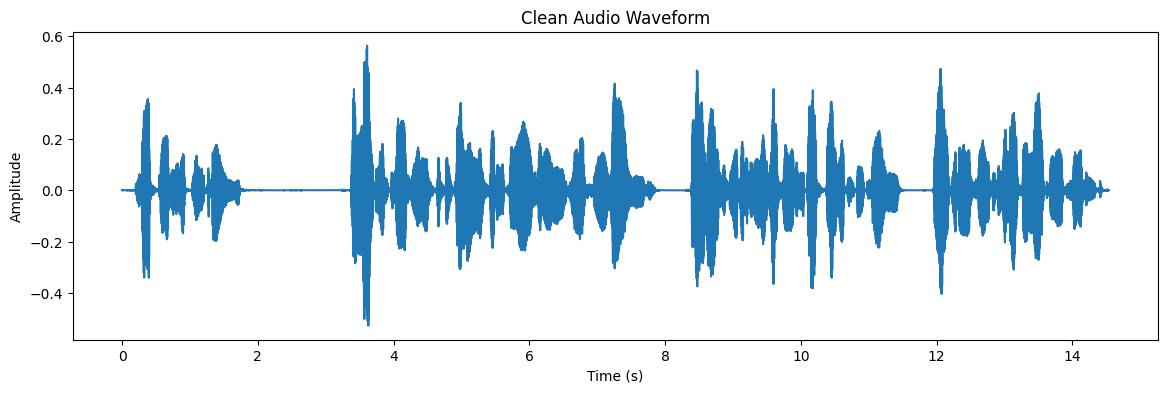

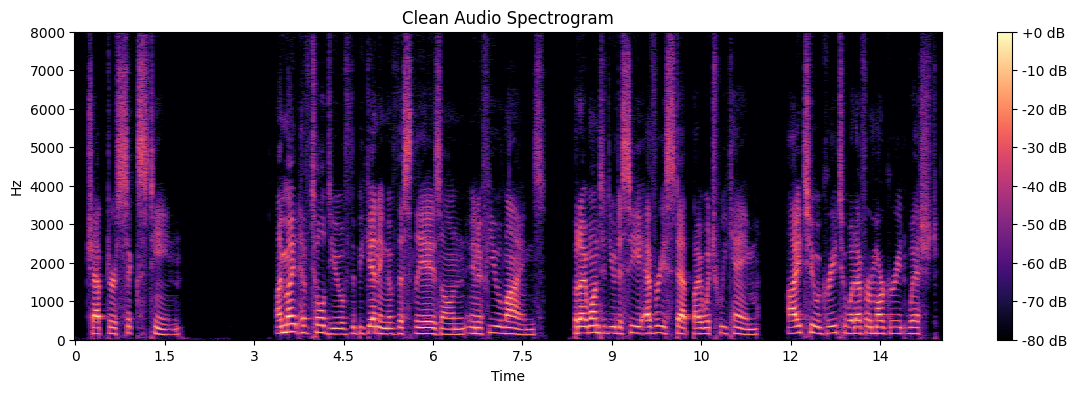

In [6]:
# Data Exploration – Audio Playback & Visualization
sample = subset[0]
audio_data = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]

display(IPyAudio(data=audio_data, rate=sampling_rate))

# Plot the audio waveform.
time_axis = np.linspace(0, len(audio_data) / sampling_rate, num=len(audio_data))
plt.figure(figsize=(14, 4))
plt.plot(time_axis, audio_data)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Clean Audio Waveform")
plt.show()

# Plot a spectrogram for additional insight.
plt.figure(figsize=(14, 4))
S = librosa.stft(audio_data)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title("Clean Audio Spectrogram")
plt.show()


In [26]:
# Define Noise Injection Functions
# For replicability (np.random.seed is outdated)
RNG = np.random.default_rng(seed=42)

def apply_gaussian_noise(data):
    global RNG
    noise_level = abs(RNG.normal(loc=0.1, scale=0.1))
    return perturbations.add_gaussian_noise(data, noise_level)

def apply_realistic_noise(data):
    global RNG
    global urbansound
    """
    Realistic noise, taken from the Urban Sound Dataset
    Fuzzes the following parameters: intensity, pitch, audio stretching, reverb
    Fuzz_map: Maps each param to a tuple of (mean, std, distribution type)
    Each random variable in fuzz map is sampled for noise generation
    """
    fuzz_map = {
        "intensity": (0.45, 0.15, "gaussian"), 
        "pitch_factor": (1, 0.3, "gaussian"), 
        "stretching_factor": (1, 0.15, "gaussian"),
        "reverb_factor": (0.01, 0.005, "gaussian")
    }
    
    params = {}
    for param in fuzz_map:
        mean, std, dist = fuzz_map[param]
        sample = mean # default to mean
        if dist == "gaussian":
            sample = abs(RNG.normal(loc=mean, scale=std))
        params[param] = sample
    num_samples = RNG.integers(1,5)

    speech_audio = np.array(data['audio']['array'])
    speech_sr = data['audio']['sampling_rate']
    speech_duration = len(speech_audio) / speech_sr

    mixed_audio = data

    for i in range(num_samples):
        urban_sample = urbansound[int(RNG.integers(len(urbansound)))]
        sound_audio = np.array(urban_sample['audio']['array'])
        sound_sr = urban_sample['audio']['sampling_rate']
        # Resample duration if needed
        if sound_sr != speech_sr:
            sound_duration = len(librosa.resample(sound_audio, orig_sr=sound_sr, target_sr=speech_sr)) / speech_sr
        else:
            sound_duration = len(sound_audio) / speech_sr
        
        # Pick random time such that sound fits within speech
        max_start_time = max(0, speech_duration - sound_duration)
        random_start_time = RNG.uniform(0, max_start_time)
        
        mixing_ratio = params["intensity"]
        mixed_audio = perturbations.overlay_audio(mixed_audio, urban_sample, mixing_ratio=mixing_ratio, start_time=random_start_time)

    # Apply remaining perturbations
    mixed_audio = perturbations.pitch_scale(mixed_audio, params["pitch_factor"])
    mixed_audio = perturbations.add_reverb(mixed_audio, params["reverb_factor"])
    mixed_audio = perturbations.time_stretch(mixed_audio, params["stretching_factor"])
        
    return mixed_audio

def apply_noise(audio_array, noise_type="clean"):
    """
    Apply noise based on noise_type:
      - "clean": No noise is added.
      - "gaussian": Add Gaussian noise.
      - "realistic": Add realistic (fuzzed) noise.
    """
    if noise_type == "clean":
        return audio_array
    elif noise_type == "gaussian":
        return apply_gaussian_noise(audio_array)
    elif noise_type == "realistic":
        return apply_realistic_noise(audio_array)
    else:
        raise ValueError("Unknown noise type")


## Some samples of noisy data

In [27]:

sample = next(iter(librispeech_train))
print(sample['text'])
gauss_sample = apply_gaussian_noise(copy.deepcopy(sample))
IPyAudio(data=gauss_sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED


In [28]:
realistic_sample = apply_realistic_noise(copy.deepcopy(sample))
IPyAudio(data=realistic_sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

# Create noisy datasets

In [ ]:
gauss_noisy_dataset = librispeech_train.map(apply_gaussian_noise)
buffer = [example for example in gauss_noisy_dataset]

# Convert to regular Dataset
dataset = Dataset.from_list(buffer)

# Save to disk
dataset.save_to_disk("gauss_noisy_dataset")

# (To load it back)
# dataset = load_from_disk("gauss_noisy_dataset")

In [ ]:
realistic_noise_dataset = librispeech_train.map(apply_realistic_noise)
buffer = [example for example in realistic_noisy_dataset]
dataset = Dataset.from_list(buffer)
dataset.save_to_disk("gauss_noisy_dataset")

In [13]:
# Define Metric Functions

def compute_snr(clean, noisy):
    """Compute Signal-to-Noise Ratio (SNR) in dB."""
    noise = clean - noisy
    snr = 10 * np.log10(np.sum(clean**2) / np.sum(noise**2) + 1e-10)
    return snr

def compute_mcd(clean, noisy, sr=16000, n_mfcc=13):
    """
    Compute Mean Cepstral Distortion (MCD) between clean and noisy signals.
    This is a rough approximation using MFCCs.
    """
    mfcc_clean = librosa.feature.mfcc(y=clean, sr=sr, n_mfcc=n_mfcc)
    mfcc_noisy = librosa.feature.mfcc(y=noisy, sr=sr, n_mfcc=n_mfcc)
    diff = mfcc_clean - mfcc_noisy
    # Euclidean distance per frame, averaged
    dist = np.sqrt(np.sum(diff**2, axis=0))
    mcd = (10.0 / np.log(10)) * np.sqrt(2) * np.mean(dist)
    return mcd


In [14]:
from transformers import WhisperForCausalLM, WhisperForConditionalGeneration, WhisperProcessor

In [15]:
# Load the Model and Processor
model_name = "openai/whisper-large-v3-turbo"  # Change if desired

processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bia

In [53]:
# Evaluate Over Multiple Noise Conditions

# Define the noise conditions and, optionally, a list of intensities for a sweep.
noise_conditions = ["clean", "gaussian", "realistic"]
intensity = 1.0  # For simplicity, use a single intensity value; you could loop over multiple values.

# Initialize dictionaries to store metrics per noise condition.
metrics = {noise: {"ground_truths": [], "predictions": [], "snrs": [], "mcds": []} 
           for noise in noise_conditions}

for noise in noise_conditions:
    print(f"Evaluating noise condition: {noise}")
    for raw_example in subset:
        # Extract clean audio data.
        example = deepcopy(raw_example)
        audio = example["audio"]
        sampling_rate = audio.get("sampling_rate", 16000)
        clean_audio = audio["array"].copy()
        
        # Apply noise according to the condition.
        noisy_data = apply_noise(example, noise_type=noise)

        noisy_audio = noisy_data["audio"]["array"]
        sampling_rate = noisy_data["audio"]["sampling_rate"]
        
        # Preprocess for model inference.
        input_features = processor(noisy_audio, sampling_rate=sampling_rate, return_tensors="pt").input_features
        input_features = input_features.to(device)
        
        # Generate transcription.
        with torch.no_grad():
            predicted_ids = model.generate(input_features)
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        
        # Save ground truth and prediction.
        metrics[noise]["ground_truths"].append(example["text"])
        metrics[noise]["predictions"].append(transcription)
        
        # Compute SNR and MCD (comparing noisy audio to clean audio).
        snr_val = 0
        mcd_val = 0

        if noise != "realistic": # realistic noise addition stretches the data making it incompatible to this analysis
            snr_val = compute_snr(clean_audio, noisy_audio)
            mcd_val = compute_mcd(clean_audio, noisy_audio, sr=sampling_rate)
        metrics[noise]["snrs"].append(snr_val)
        metrics[noise]["mcds"].append(mcd_val)
        
        # Print for inspection.
        print(f"Noise: {noise}")
        print("Ground Truth:", example["text"])
        print("Prediction:  ", transcription)
        print(f"SNR: {snr_val:.2f} dB, MCD: {mcd_val:.2f}")
        print("-" * 30)
    print("\n")
    
# Compute aggregate metrics using jiwer for transcription quality.
results = {}
for noise in noise_conditions:
    wer_val = jiwer.wer(metrics[noise]["ground_truths"], metrics[noise]["predictions"])
    cer_val = jiwer.cer(metrics[noise]["ground_truths"], metrics[noise]["predictions"])
    avg_snr = np.mean(metrics[noise]["snrs"])
    avg_mcd = np.mean(metrics[noise]["mcds"])
    results[noise] = {"WER": wer_val, "CER": cer_val, "Avg_SNR": avg_snr, "Avg_MCD": avg_mcd}

print("Aggregate Evaluation Results:")
for noise, res in results.items():
    print(f"{noise.capitalize()} Condition:")
    print(f"  WER (word error rate): {res['WER']:.2%}")
    print(f"  CER (character error rate): {res['CER']:.2%}")
    print(f"  Average SNR (signal-to-noise ratio): {res['Avg_SNR']:.2f} dB")
    print(f"  Average MCD (mean cepstral distortion): {res['Avg_MCD']:.2f}")
    print("-" * 40)


Evaluating noise condition: clean


/tmp/ipykernel_237260/3822653414.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(np.sum(clean**2) / np.sum(noise**2) + 1e-10)


Noise: clean
Ground Truth: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Prediction:    chapter sixteen i might have told you of the beginning of this liaison in a few lines but i wanted you to see every step by which we came i too agree to whatever marguerite wished
SNR: inf dB, MCD: 0.00
------------------------------
Noise: clean
Ground Truth: MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN
Prediction:    marguerite to be unable to live apart from me it was the day after the evening when she came to see me that i sent her manon le scott from that time seeing that i could not change my mistress's life i changed my own
SNR: inf dB, MCD: 0.00
------------------------------
Noise: clean
Groun

In [ ]:
# Cell 8: Qualitative Evaluation – Visualize Clean vs. Noisy Audio

# Select one sample from the subset for a detailed qualitative comparison.
sample = subset[0]
clean_audio = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]

# Generate noisy versions for each noise condition.
noisy_versions = {noise: apply_noise(clean_audio, noise_type=noise, intensity=1.0) for noise in noise_conditions if noise != "clean"}
noisy_versions["clean"] = clean_audio  # Include clean audio for comparison

# Display audio players for each condition.
for noise, audio_version in noisy_versions.items():
    print(f"Audio for {noise.capitalize()} condition:")
    display(IPyAudio(data=audio_version, rate=sampling_rate))

# Plot spectrograms side-by-side for visual comparison.
fig, axes = plt.subplots(1, len(noisy_versions), figsize=(16, 4))
for ax, (noise, audio_version) in zip(axes, noisy_versions.items()):
    S = librosa.stft(audio_version)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='hz', ax=ax)
    ax.set_title(f"{noise.capitalize()} Audio")
    ax.label_outer()
fig.colorbar(img, ax=axes, format='%+2.0f dB')
plt.show()


In [ ]:
# Visualize Metrics Summary Across Noise Conditions
import pandas as pd

# Create a DataFrame from the aggregate results.
df_results = pd.DataFrame(results).T
df_results.index.name = "Noise Condition"
print(df_results)

# Plot a bar chart for WER and CER.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df_results["WER"].plot(kind="bar", ax=ax[0], color="skyblue", title="WER by Noise Condition")
ax[0].set_ylabel("WER")

df_results["CER"].plot(kind="bar", ax=ax[1], color="salmon", title="CER by Noise Condition")
ax[1].set_ylabel("CER")

plt.tight_layout()
plt.show()

